**This notebook shows how machine learning techniques  can apply in Semi-conductor Industry.**

**Our Objective:** To identify different types of wafer map failure pattern automatically instead of manual work, so that the semi-conductor fabrication can improve on the yield of wafers manufacturing process.

Here, we list all reference:

[1]Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets [paper downloas link](http://ieeexplore.ieee.org/document/6932449/)

[2]Wafer Defect Patterns Recognition Based on OPTICS and Multi-Label Classification [paper download link](http://ieeexplore.ieee.org/document/7867343/)

**Step1:  Define your problem**

* **Input:** WM-811K dataset provided by *[MIR lab]*(http://mirlab.org/dataSet/public/). 

  *(For convenience, I have converted the original (dot)mat file to (dot)pkl file and you may download from this kernel.)*

* **Model:** One-VS-One multi-class SVMs. 

* **Output:** Failure pattern labels.

reference: https://cvlab.tistory.com/54?category=491498
https://www.kaggle.com/cchou1217/wm-811k-wafermap

In [1]:
# loading libraries
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import plotly.graph_objects as graph
import itertools
from plotly.subplots import make_subplots
from tensorflow.keras import layers,Input,models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,Input, AveragePooling2D,BatchNormalization,Activation,ZeroPadding2D,concatenate,Add
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session,get_value,set_value
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import sys
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard,LearningRateScheduler,EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow import keras
import keras_tuner as kt


from IPython.display import Image
import os
import cv2
import warnings
#%matplotlib inline 
#print(os.listdir("c:/Users/user/Desktop"))
warnings.filterwarnings("ignore")
fault_mapping = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','None']
from preparing import savefile,loadfile,acc_plot,core_select
from preparing import confusion_matrix_display,remove_unwanted_x,OnehotX
#print(device_lib.list_local_devices())
core_select('GPU')
#import shutil
#shutil.rmtree('my_log', ignore_errors=True)
tensorboard = TensorBoard(log_dir='my_log')
#Run command at terminal: tensorboard --logdir=G:\我的雲端硬碟\Colab_Notebooks\WAFER\Program\my_log 
#Check tensorboard at "http://localhost:6006/
#Reference : https://docs.pythontab.com/tensorflow/how_tos/summaries_and_tensorboard/
waferSizeX=48
waferSizeY=48
default_decay_lr10=(1./0.9 -1)/128  #每128 batch , 下降10%
default_decay_lr20=(1./0.8 -1)/128  #每128 batch , 下降20%
default_decay_lr30=(1./0.7 -1)/128  #每128 batch , 下降30%
default_decay_lr40=(1./0.6 -1)/128  #每128 batch , 下降40%
default_ES = EarlyStopping(monitor='val_acc',min_delta=0.0001, patience=3,restore_best_weights=True,verbose=1,mode="auto")

#==============
test_type=2
#==============
if test_type==0:
    filename='split'
    chartname='Org'
elif test_type==1: 
    filename='dbscan'
    chartname='DBSCAN'
elif test_type==2:
    filename='autoencoder'
    chartname='Auto Encoder'
#list_name=[['split','Org'],['dbscan','DBSCAN'],['autoencoder','Auto Encoder']]
    
CNN_MODEL_ENABLE=False    
LENET_MODEL_ENABLE=False
ALEXNET_MODEL_ENABLE=False
VGG16_MODEL_ENABLE=False
RESNET18_MODEL_ENABLE=False
RESNET50_MODEL_ENABLE=True
GOOGLENET_MODEL_ENABLE=False
PREDICT_MODEL_ENABLE=False

orgx_train,orgy_train=loadfile('%s_train_onehot%s_%s'%(filename,waferSizeX,waferSizeY))
orgx_test,orgy_test=loadfile('%s_test_onehot%s_%s'%(filename,waferSizeX,waferSizeY))
orgx_validate,orgy_validate=loadfile('%s_validate_onehot%s_%s'%(filename,waferSizeX,waferSizeY))
np.set_printoptions(threshold=80)
print('train_x_shape:%s'%str(orgx_train.shape))
print('train_y_shape:%s'%str(orgy_train.shape))
print('test_x_shape:%s'%str(orgx_test.shape))
print('test_y_shape:%s'%str(orgy_test.shape))
print('validate_x_shape:%s'%str(orgx_validate.shape))
print('validate_y_shape:%s'%str(orgy_validate.shape))

File Load:autoencoder_train_onehot48_48
File Load:autoencoder_test_onehot48_48
File Load:autoencoder_validate_onehot48_48
train_x_shape:(24336, 48, 48, 3)
train_y_shape:(24336, 8)
test_x_shape:(6955, 48, 48, 3)
test_y_shape:(6955, 8)
validate_x_shape:(3479, 48, 48, 3)
validate_y_shape:(3479, 8)


# MACRO & MODELS

In [2]:
from models import cnn,LeNet,AlexNet,vgg16,ResNet18,ResNet50,googLeNet
#from models import hypercnn
#===================================
#================
def loaddata():
#================    
    return orgx_train,orgy_train,orgx_test,orgy_test,orgx_validate,orgy_validate
#================
def image_resize(images, img_rows, img_cols, normalize=False):
#================
    #    images：要讀取的圖片
    #    img_rows:圖片行
    #    img_cols:圖片列
    imgs = []
    for img in images:
        # Reduce size
        resized = cv2.resize(img, (img_cols, img_rows))
        if normalize:
            resized = resized.astype('float32')
            resized /= 127.5
            resized -= 1.  
        imgs.append(resized)
    return np.array(imgs).reshape(len(images), img_rows, img_cols,3)
#================
def mini_batch(X_train, Y_train, batch_size, img_w=224, img_h=224, is_argumentation=False):
#================
    #    X_train：所有圖片
    #    y_train: 所有圖片對應的標籤列表
    #    batch_size:批次
    #    img_w:圖片寬
    #    img_h:圖片高
    #    is_argumentation:是否需要資料增強
    #    一個generator，x: 獲取的批次圖片 y: 獲取的圖片對應的標籤
    while 1:
        for i in range(0, len(X_train), batch_size):
            x = image_resize(X_train[i:i+batch_size], img_w, img_h)
            y = Y_train[i:i+batch_size]
            if is_argumentation==True:
                # 資料增強
                x, y = img_augmentation(x, y)
            yield(x,y) # 最重要的就是這個yield，它代表返回，返回以後迴圈還是會繼續，然後再返回。就比如有一個機器一直在作累加運算，但是會把每次累加中間結果告訴你一樣，直到把所有數加完
#================
def mini_batchX(X_train, batch_size, img_w=224, img_h=224):
#================
    while 1:
        for i in range(0, len(X_train), batch_size):
            x = image_resize(X_train[i:i+batch_size], img_w, img_h)
            yield(x)
#================            
def build_model(x_train,y_train,x_validate,y_validate,model,savename,batch_size=128,epochs=100,verbose=1,use_mini_batch=False,loss='categorical_crossentropy',optimizer=Adam(decay=default_decay_lr10),plottitle=''):
#================
    clear_session()
    model.compile(loss=loss,optimizer=optimizer,metrics=['acc'])
    if use_mini_batch==True:
        #ax_train, x_valid, ay_train, y_valid = train_test_split(x_train,y_train, test_size=0.1)
        mhistory = model.fit_generator(
            generator=mini_batch(x_train,y_train,batch_size),
            steps_per_epoch=len(x_train)//batch_size, 
            epochs=epochs,verbose=verbose,
            validation_data=mini_batch(x_validate, y_validate,batch_size),
            validation_steps=len(y_test)//batch_size
        )     
    else:
        mhistory = model.fit(x=x_train,y=y_train,validation_data=(x_validate,y_validate),batch_size=batch_size,epochs=epochs,verbose=verbose,callbacks=[tensorboard , default_ES])
    acc_plot('%s Model Accuracy'%plottitle,'%s Model Loss'%plottitle,savename,mhistory)
#    if os.path.exists('./trained_model/%s_Model.h5'%title):
#        os.remove('./trained_model/%s_Model.h5'%title)
#        os.remove('./trained_model/%s_weights.h5'%title)
    model.save('./trained_model/%s_Model.h5'%savename)
    model.save_weights('./trained_model/%s_weights.h5'%savename)
#    np.savez('./report_chart/report_%s.npz'%plottitle, mhistory.history)
    a=mhistory.history
    np.savez('./report_chart/report_%s.npz'%plottitle, loss=a['loss'],acc=a['acc'],val_loss=a['val_loss'],val_acc=a['val_acc'])
    return mhistory




#================
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
#================
#cm:混淆矩阵值
#classes:分类标签
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('%s Confusion Matrix'%title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j]!=0:
            plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black") #,bbox=(dict(facecolor='white')))
#    plt.grid()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./report_chart/%s_CM.jpg'%title, bbox_inches='tight', dpi=150)
    return
#================
def report_confustion_matrix(x_test,y_test,title,plottitle,batch_size=128,use_mini_batch=False):
#================
    clear_session()
    model = load_model('./trained_model/%s_Model.h5'%title)
    if use_mini_batch==True:
        total=(len(y_test)//batch_size)*batch_size
        nx_test=x_test[:total]
        y_test=y_test[:total]
        Y_pred = model.predict_generator(generator=mini_batchX(nx_test,batch_size),steps=len(x_test)//batch_size)
    else:
        Y_pred = model.predict(x=x_test,batch_size=batch_size)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test=y_test.argmax(1)
    #print(confusion_matrix(y_test, y_pred))
    cm=confusion_matrix(y_test, y_pred,normalize='true')
    cm=np.round(cm,decimals=2)
    plot_confusion_matrix(cm=cm,classes=fault_mapping[:8],title=plottitle)    
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='./report_chart/%s_Model.png'%title)
    print('Classification Report')
    table=classification_report(y_test, y_pred, target_names=fault_mapping[:8])
    print(table)
    report=classification_report(y_test, y_pred,target_names=fault_mapping[:8], output_dict=True)
    #report=classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df['precision']=df['precision'].round(3)*100
    df['recall']=df['recall'].round(3)*100
    df['f1-score']=df['f1-score'].round(3)*100
    df['support']=df['support'].astype('int')
    df.to_csv('./report_chart/REPORT_CM_%s.csv'%plottitle)
    return

Input shape: Inxdex,waferSizeX,wafeSizeY,OneHot

# CNN2
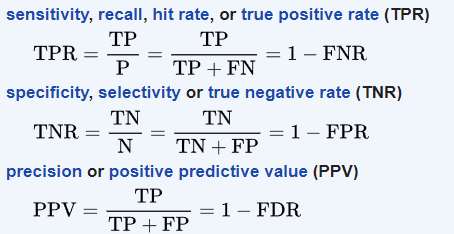

In [3]:
if CNN_MODEL_ENABLE==True:    
    x_train,y_train,x_test,y_test,x_validate,y_validate=loaddata()
    mhistory=build_model(x_train,y_train,x_validate,y_validate,cnn(waferSizeX,waferSizeY),savename='CNN_%s'%filename,plottitle='CNN %s'%chartname)
    report_confustion_matrix(x_test,y_test,'CNN_%s'%filename,plottitle='CNN %s'%chartname)
    Image(retina=True, filename='./report_chart/CNN_%s_Model.png'%filename)

# LeNet - 5

Reference:https://medium.com/ching-i/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1-cnn-%E7%B6%93%E5%85%B8%E6%A8%A1%E5%9E%8B-lenet-alexnet-vgg-nin-with-pytorch-code-84462d6cf60c
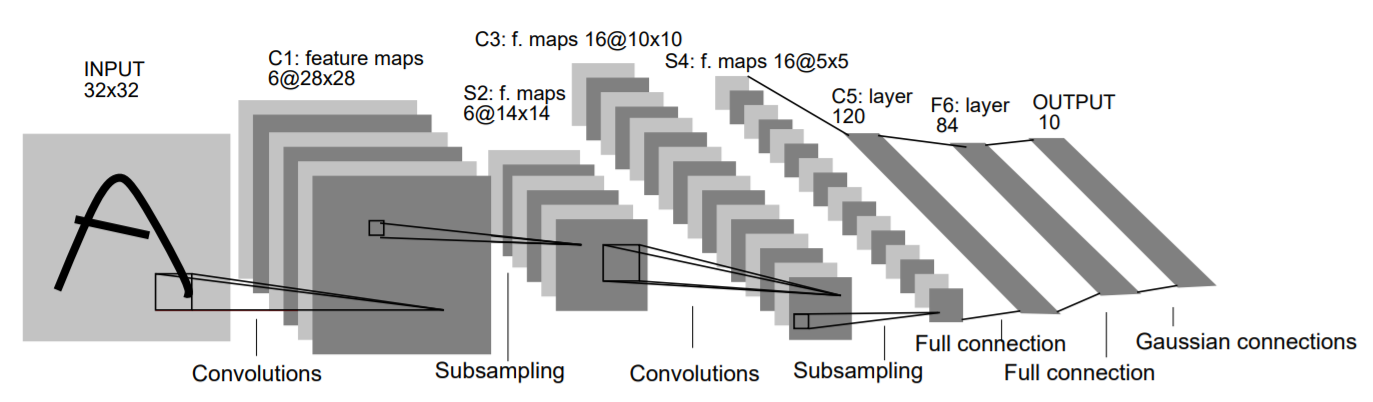
官網: http://yann.lecun.com/exdb/lenet/
官網: https://www.jianshu.com/p/6beedc7f83da

In [4]:
if LENET_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test,x_validate,y_validate=loaddata()
    mhistory=build_model(x_train,y_train,x_validate,y_validate,LeNet(waferSizeX,waferSizeY),savename='LeNet_%s'%filename,plottitle='LeNet-5 %s'%chartname)
    report_confustion_matrix(x_test,y_test,'LeNet_%s'%filename,plottitle='LeNet %s'%chartname)
    #Image(retina=True, filename='./trained_model/LeNet_%s_Model.png'%filename)

# AlexNet
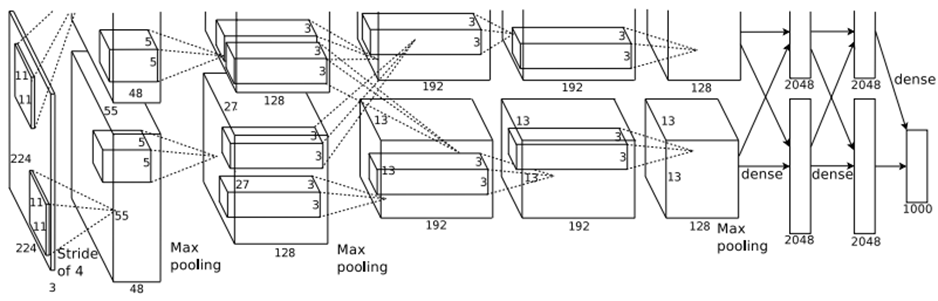

Reference: https://medium.com/ching-i/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1-cnn-%E7%B6%93%E5%85%B8%E6%A8%A1%E5%9E%8B-lenet-alexnet-vgg-nin-with-pytorch-code-84462d6cf60c
Reference: https://blog.csdn.net/DeepLearningJay/article/details/107971526
Reference: https://www.mydatahack.com/building-alexnet-with-keras/

In [5]:
if ALEXNET_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test,x_validate,y_validate=loaddata()
    mhistory=build_model(x_train,y_train,x_validate,y_validate,AlexNet(waferSizeX,waferSizeY),savename='AlexNet_%s'%filename,verbose=1,
                         optimizer=Adam(learning_rate=0.0001),plottitle='AlexNet %s'%chartname) #optimizer=Adam(learning_rate=0.000025) default_decay_lr30
    report_confustion_matrix(x_test,y_test,'AlexNet_%s'%filename,plottitle='AlexNet %s'%chartname)
    #Image(retina=True, filename='./trained_model/AlexNet_%s_Model.png'%filename)
    

# VGG 16
reference: https://blog.csdn.net/qq_41078023/article/details/105509700

In [6]:
if VGG16_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test,x_validate,y_validate=loaddata()
#    optimizer=Adam(learning_rate=0.000025) default_decay_lr30
    mhistory=build_model(x_train,y_train,x_validate,y_validate,
                         vgg16(waferSizeX,waferSizeY),
                         optimizer=Adam(default_decay_lr30),
                         savename='VGG16_%s'%filename,
                         verbose=1,
                         plottitle='VGG16 %s'%chartname)
    report_confustion_matrix(x_test,y_test,'VGG16_%s'%filename,plottitle='VGG16 %s'%chartname)
    #Image(retina=True, filename='./trained_model/VGG16_%s_Model.png'%filename)    
    


# ResNet 18
https://blog.csdn.net/weixin_40893939/article/details/99697725https://blog.csdn.net/weixin_40893939/article/details/99697725

In [7]:
if RESNET18_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test,x_validate,y_validate=loaddata()
    mhistory=build_model(x_train,y_train,x_validate,y_validate,
                         ResNet18(waferSizeX,waferSizeY),
                         optimizer=Adam(default_decay_lr10), #optimizer=Adam(learning_rate=0.000025) default_decay_lr30
                         savename='ResNet18_%s'%filename,
                         verbose=1,
                         plottitle='ResNet18 %s'%chartname)
    report_confustion_matrix(x_test,y_test,'ResNet18_%s'%filename,plottitle='ResNet18 %s'%chartname)
    #Image(retina=True, filename='./trained_model/RESNET50_%s_Model.png'%filename)


# Resnet 50
https://blog.csdn.net/weixin_40893939/article/details/99697725https://blog.csdn.net/weixin_40893939/article/details/99697725

Epoch 1/100
191/191 [==============================] - 20s 78ms/step - loss: 0.9910 - acc: 0.6104 - val_loss: 0.6322 - val_acc: 0.7729
Epoch 2/100
191/191 [==============================] - 14s 71ms/step - loss: 0.5038 - acc: 0.8124 - val_loss: 0.4532 - val_acc: 0.8359
Epoch 3/100
191/191 [==============================] - 13s 71ms/step - loss: 0.3947 - acc: 0.8570 - val_loss: 0.5630 - val_acc: 0.8094
Epoch 4/100
191/191 [==============================] - 13s 70ms/step - loss: 0.3558 - acc: 0.8680 - val_loss: 0.3738 - val_acc: 0.8758
Epoch 5/100
191/191 [==============================] - 13s 69ms/step - loss: 0.3209 - acc: 0.8816 - val_loss: 0.3189 - val_acc: 0.8847
Epoch 6/100
191/191 [==============================] - 13s 70ms/step - loss: 0.2873 - acc: 0.8949 - val_loss: 0.3429 - val_acc: 0.8727
Epoch 7/100
191/191 [==============================] - 13s 70ms/step - loss: 0.2506 - acc: 0.9066 - val_loss: 0.3320 - val_acc: 0.8813
Epoch 8/100
191/191 [==============================] - 

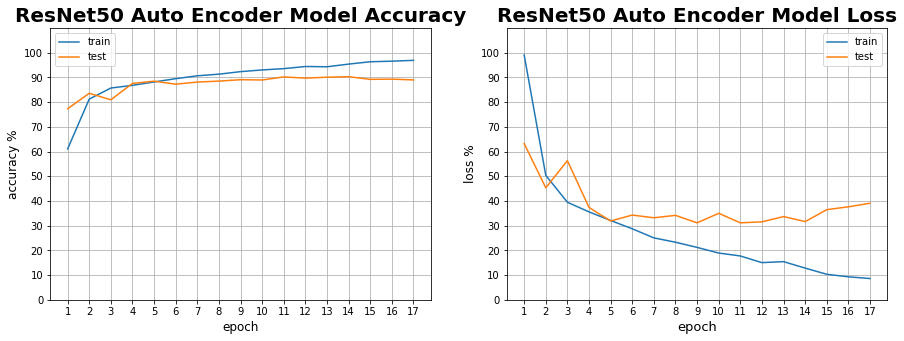

Classification Report
              precision    recall  f1-score   support

      Center       0.95      0.95      0.95      1000
       Donut       0.92      0.97      0.95       727
    Edge-Loc       0.85      0.81      0.83       999
   Edge-Ring       0.96      0.94      0.95       999
         Loc       0.83      0.78      0.81       999
      Random       0.93      0.96      0.95      1000
     Scratch       0.83      0.89      0.86       999
   Near-full       0.98      0.91      0.94       232

    accuracy                           0.90      6955
   macro avg       0.91      0.90      0.90      6955
weighted avg       0.90      0.90      0.90      6955



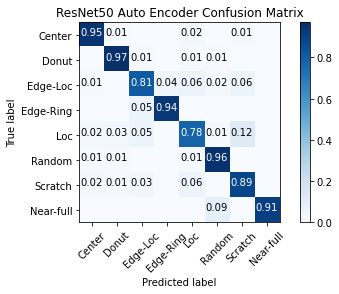

In [8]:
if RESNET50_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test,x_validate,y_validate=loaddata()
    mhistory=build_model(x_train,y_train,x_validate,y_validate,
                         ResNet50(waferSizeX,waferSizeY),
                         optimizer=Adam(default_decay_lr10), #optimizer=Adam(learning_rate=0.000025) default_decay_lr30
                         savename='ResNet50_%s'%filename,
                         verbose=1,
                         plottitle='ResNet50 %s'%chartname)
    report_confustion_matrix(x_test,y_test,'ResNet50_%s'%filename,plottitle='ResNet50 %s'%chartname)
    #Image(retina=True, filename='./trained_model/RESNET50_%s_Model.png'%filename)

# googLeNet
reference: https://www.cnblogs.com/dengshunge/p/10808191.html
![image.png](attachment:d21ed281-c537-43d1-a070-4d5f1f502209.png)

In [ ]:
if GOOGLENET_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test=loaddata()
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    build_model(x_train,y_train,googLeNet(224,224),savename='googLeNet_%s'%filename,batch_size=64,verbose=1,use_mini_batch=True,optimizer=sgd,plottitle='googLeNet %s'%chartname)
    report_confustion_matrix(x_test,y_test,'googLeNet_%s'%filename,plottitle='googLeNet %s'%chartname,batch_size=64,use_mini_batch=True)
    #Image(retina=True, filename='./trained_model/googLeNet_%s_Model.png'%filename)


# Model 預測

In [ ]:
if PREDICT_MODEL_ENABLE==True:
    x_train,y_train,x_test,y_test=loaddata()
    # -- 載入模型 -- #
    model_name=['cnn','LeNet','vgg16','Resnet18','Resnet50']
    for i,model in enumerate(model_name):
        model = load_model('%s_%s_Model.h5'%(model_name[i],filename))
        # -- 使用測試資料評估神經網路 -- #
        test_loss, test_val = model.evaluate(x_test, y_test, verbose=0)
        print('%s測試資料損失值:%.2f%%,準確度:%.2f%%'%(model_name[i], test_loss*100,test_val*100))

    #Use min_batch
    model_name=['AlexNet','googLeNet']
    for i,model in enumerate(model_name):
        model = load_model('%s_%s_Model.h5'%(model_name[i],filename))
        # -- 使用測試資料評估神經網路 -- #
        batch_size=64
        test_loss, test_val = model.evaluate_generator(generator=mini_batch(x_test,y_test,batch_size),steps=len(x_test)//batch_size)
        print('%s測試資料損失值:%.2f%%,準確度:%.2f%%'%(model_name[i], test_loss*100,test_val*100))    
    

# Confusion Matrix
https://en.wikipedia.org/wiki/Confusion_matrix

#Precision:
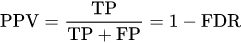
#recall
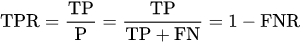
#f1 score:
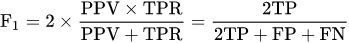
#Accuracy:
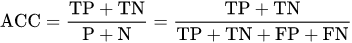

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(load_x, load_y, test_size=0.2)
# -- 載入模型 -- #
model_name='CNN2'
model = load_model('%s%s_Model.h5'%(save_title,model_name))
Y_pred = model.predict_generator(x_test)
y_pred = np.argmax(Y_pred, axis=1)
y_test=y_test.argmax(1)

#print(confusion_matrix(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred,normalize='true')
cm=np.round(cm,decimals=2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=fault_mapping[:8])
disp.plot(xticks_rotation=45,cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=fault_mapping[:8]))

In [ ]:
new_x,new_y=remove_unwanted_x('CNN2',4,x_test,y_test,0.9)

In [ ]:
new_x,new_y=remove_unwanted_x('CNN2',6,new_x,new_y,0.9)

In [ ]:
confusion_matrix_display('CNN2','true',new_x,new_y)

In [ ]:
def confusion_matrix(model_name,org_x,org_y):
    model = load_model('%s_Model.h5'%model_name)
    Y_pred = model.predict_generator(org_x)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test=org_y
    cm=confusion_matrix(y_test, y_pred,normalize=None)
    cm=np.round(cm,decimals=2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=fault_mapping[:8])
    disp.plot(xticks_rotation=45,cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    print('Classification Report')
    print(classification_report(y_test, y_pred, target_names=fault_mapping[:8]))

In [ ]:
def remove_unwanted_xa(model_name,remove_fail,org_x,org_y,remove_percent):
    '''
    model_name:'CNN2' or others
    remove_fail:Unwanted fail type (0-7)
    org_x: test x data which are used for prediction (hot coding)
    org_y: test y data which are used for prediction (non hot coding)
    remove_percent: 1=100% remove unwanted fail
    '''
    model = load_model('%s.h5'%(model_name))
    predict_list = model.predict(org_x)
    predict_list = np.argmax(predict_list.round(1),axis=1)
    true_list=org_y
    #true_list=np.argmax(y_test.round(1),axis=1)
    true_index=np.where(true_list==remove_fail)
    true_index=true_index[0]
    predict_fail_index=[]
    for i in true_index:
        if predict_list[i]!=remove_fail:
            predict_fail_index.append(i)
    print('total miss predict:%s'%(len(predict_fail_index)))
    percent=int(len(predict_fail_index)*remove_percent)
    predict_fail_index=predict_fail_index[0:percent]
    wrong_count=[0,0,0,0,0,0,0,0]
    for i in range (len(predict_fail_index)):
        a=predict_list[predict_fail_index[i]]
        wrong_count[a]+=1
    print('=====================')
    total=0
    for i,j in enumerate(wrong_count):
        print('guess %s %s: %s'%(i,fault_mapping[i],j))
        total=total+j
    print('=====================')
    print('total removed %s%%:%s'%(remove_percent*100,total))
    return predict_fail_index

#==================
def showfailtmap(x,fail_index):
#==================
    fig,ax=plt.subplots(nrows=(len(fail_index)//10)+1,ncols=10,figsize=(15,15))
    ax=ax.ravel(order='C')
    for index in range(0,len(fail_index)):
        ax[index].imshow(x[fail_index[index]],cmap=plt.cm.bone)
        ax[index].set_title(fail_index[index],color='red')
        ax[index].set_xticks([])
        ax[index].set_yticks([])
    plt.tight_layout()
    plt.show()
    
#'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'None':8
x_train, x_test, y_train, y_test = train_test_split(load_x, load_y, test_size=0.2) 
fail_index=remove_unwanted_xa('%sCNN2_Model'%(save_title),4,x_test,y_test,1)


# CNN 1

In [ ]:
# 預處理訓練資料
x = np.zeros((len(load_x),waferSizeX , waferSizeY))
for w in range(len(load_x)):
    for i in range(waferSizeX):
            x[w, i]=load_x[w][i].argmax(1) 
y=load_y.argmax(1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)
x_train = x_train.reshape((len(x_train), waferSizeX * waferSizeY)) #←將 (60000,48,48) 轉換成 (60000,48X48)
x_train = x_train.astype('float32') / 255                          #再將 0~255 的像素值轉換成 0~1 的浮點數
x_test = x_test.reshape((len(x_test), waferSizeX * waferSizeY))    #將 10000 筆測試樣本做同樣的轉換
x_test = x_test.astype('float32') / 255         
# 預處理標籤資料
y_train = to_categorical(y_train)                                  #將標籤做 One-hot 編碼
y_test  = to_categorical(y_test)                                   #將測試做 One-hot 編碼
#程 建立多元分類模型
model = Sequential()                                               #建立序列模型物件
model.add(Dense(512, activation='relu', input_dim=waferSizeX * waferSizeY )) #加入第一層
model.add(Dense(256, activation='relu')) #加入第一層
model.add(Dense(8, activation='softmax'))                          #加入第二層
model.compile(optimizer='adam',                                    #指定優化器rmsprop
              loss='categorical_crossentropy',                     #指定損失函數
              metrics=['acc'])                                     #指定評量準則
#訓練模型
cnn1_history = model.fit(x_train, y_train, epochs=30, batch_size=128)
#評估模型成效
test_loss, test_acc = model.evaluate(x_test, y_test)               #使用測試樣本及標籤來評估普適能力
print('對測試資料集的準確率：', test_acc)
#畫出測試圖片並標示預測結果與標準答案
predict = model.predict(x_test)                            #用測試樣本進行預測
plt.gcf().set_size_inches(15, 4)                                   #設定圖形的尺吋
for i in range(5):
    ax = plt.subplot(1, 5, 1+i)                                    #設定 1x5 的子圖表, 目前要畫第 1+i 個
    ax.imshow(x[i], cmap='binary')                                 #顯示灰階圖片
    ax.set_title('label = '+str(y[i]) + '\npredi = '+str(predict[i]), fontsize=18) #←設定標題
    ax.set_xticks([]); ax.set_yticks([])                           #X, Y 軸不顯示刻度
plt.show()                                                         #將圖形顯示出來

#程 將模型存檔
#model.save('MnistModel.h5')   #← 將模型以指定的檔名存檔

# Auto Keras

In [ ]:
#x,y=loadfile('fail_pattern%s_%s'%(waferSizeX,waferSizeY))
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(load_x, load_y, test_size=0.3, random_state=2022)
np.set_printoptions(threshold=80)
print(x_train.shape)
print(y_train.shape)
import autokeras as ak
# Initialize the ImageClassifier.
clf = ak.ImageClassifier(max_trials=1)
# Search for the best model.
history=clf.fit(x_train, y_train, epochs=20)
# Evaluate on the testing data.
print("Accuracy: {accuracy}".format(accuracy=clf.evaluate(x_test, y_test)))


predicted_y = clf.predict(x_test)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

history.model.summary()

history.model.save("wm_model_autokeras", save_format="tf")

history.model.metrics_names

# SKLEARN KFOLD

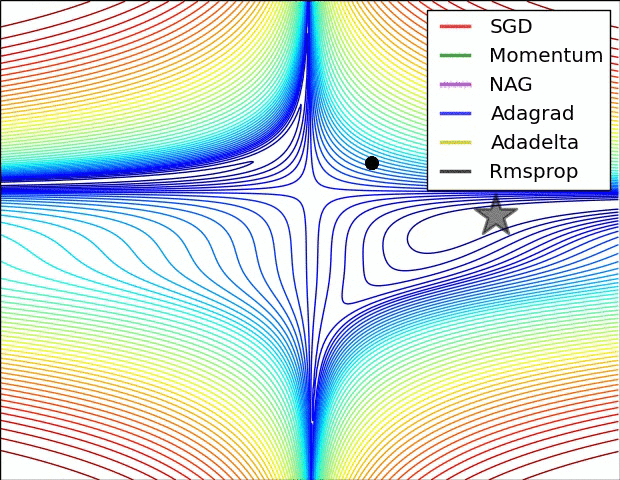
# https://www.datasciencecentral.com/an-overview-of-gradient-descent-optimization-algorithms/

# 分群 (UNSUPERVISED LEARNING)
# Density Based Clustering (DBSCAN)
https://ithelp.ithome.com.tw/articles/10193760
https://ithelp.ithome.com.tw/articles/10194172
https://www.cnblogs.com/pinard/p/6217852.html
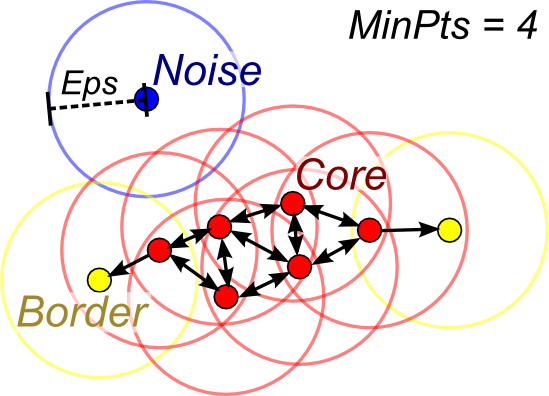

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(load_x,load_y.argmax(1), test_size=0.9, random_state=2022)
# kmeans
for name, X, Y in datas:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=kmeans, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_kmeans')
    plt.savefig(os.path.join('pic', name+'_kmeans'))
    plt.show()
    
# hierarchical clustering: single link
linkage = ['ward', 'average', 'complete']
for name, X, Y in datas:
    hierarchy = AgglomerativeClustering(linkage=linkage[0], n_clusters=n_clusters).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=hierarchy, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_single')
    plt.savefig(os.path.join('pic', name+'_single'))
    plt.show()
    
# hierarchical clustering: average link
for name, X, Y in datas:
    n_clusters = len(set(Y))
    hierarchy = AgglomerativeClustering(linkage=linkage[1], n_clusters=n_clusters).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=hierarchy, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_average')
    plt.savefig(os.path.join('pic', name+'_average'))
    plt.show()
    
# hierarchical clustering: complete link
for name, X, Y in datas:
    n_clusters = len(set(Y))
    hierarchy = AgglomerativeClustering(linkage=linkage[2], n_clusters=n_clusters).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=hierarchy, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_complete')
    plt.savefig(os.path.join('pic', name+'_complete'))
    plt.show()
    
# dbscan
for name, X, Y in datas:
    n_clusters = len(set(Y))
    dbscan = DBSCAN(eps=0.3).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=dbscan, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_dbscan')
    plt.savefig(os.path.join('pic', name+'_dbscan'))
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline
X1, y1=datasets.make_circles(n_samples=5000, factor=.6,
                                      noise=.05)
X2, y2 = datasets.make_blobs(n_samples=1000, n_features=2, centers=[[1.2,1.2]], cluster_std=[[.1]],
               random_state=9)

X = np.concatenate((X1, X2))
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.show()

In [ ]:
X

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(load_x,load_y.argmax(1), test_size=0.9, random_state=2022)

In [ ]:
X=x_train[0].astype('float32')
plt.imshow(X)

In [ ]:
faddress=[]
x=np.argmax(x_train[0], axis=2)
np.set_printoptions(linewidth=98)
for i in range (waferSizeX):
    for j in range(waferSizeY):
        if x[i][j]==1:
            x[i][j]=0
        if x[i][j]==2:
            temp=[i,j]
            faddress.append(temp)
add=np.array(faddress)
plt.figure(figsize=(5,5))
plt.xlim(0,48)
plt.ylim(0,48)
plt.scatter(add[:,0],add[:,1], cmap=plt.cm.Spectral);
plt.title('original')
plt.show()


In [ ]:
y_pred = DBSCAN(eps = 2, min_samples = 5, metric = 'euclidean',algorithm ='auto').fit_predict(add)
plt.figure(figsize=(5,5))
plt.xlim(0,48)
plt.ylim(0,48)
plt.scatter(add[:, 0], add[:, 1],c=y_pred)
plt.show()
y_pred

In [ ]:
#eps:兩個樣本之間的最大距離
#min_samples:將一個點視為核心點的鄰域中的樣本數
db = DBSCAN(eps=2, min_samples=5, metric = 'euclidean',algorithm ='auto')
db.fit(add)
result=db.components_

In [ ]:

plt.figure(figsize=(5,5))
plt.xlim(0,48)
plt.ylim(0,48)
plt.scatter(result[:,0],result[:,1], cmap=plt.cm.Spectral);
plt.title('new')
plt.show()